<a href="https://colab.research.google.com/github/danb-neo4j/patient_journey/blob/main/patientJourney_tabularEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Patient Journey Demo: Tabular Exploratory Data Analysis
In this notebook we perform exploratory data analysis (EDA) on the tabular [Synthea Synthetic Patient Data](https://synthea.mitre.org/) before loading it into Neo4j. This patient journey demo uses generated Synthea data for approximately 5,000 patients. A smaller Synthea data set is published to the [Github repo](https://www.packtpub.com/product/graph-data-processing-with-cypher/9781804611074) associated with the book [Graph Data Processing with Cypher](https://www.packtpub.com/product/graph-data-processing-with-cypher/9781804611074).

Tabular EDA is critical to understanding the contents of non-graph data as you design a graph data model. For more background about EDA in the context of Neo4j and graph data models, I recommend [my Road to NODES 2022 Workshop](https://www.youtube.com/live/oG9InPntehQ?feature=share) on the topic. 

The Synthea data contains a multiple CSVs, but with this notebook we will focus on only the subset of the data we use in the rest of the demo:
* Patients
* Encounters
* Procedures
* Medications (Drugs)

# Import Libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette("colorblind")
sns.set(rc={'figure.figsize':(12,7)})

import os
import configparser
from IPython.display import Image
from datetime import datetime, date

# Mount Google Drive

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# change working directory 
os.chdir('drive/MyDrive/Colab Notebooks/gds_demos/patient_journey/')
DATA_DIRECTORY = 'data/'

# Patient Data

## Overview

In [4]:
# read-in patient data 
patient_df = pd.read_csv(DATA_DIRECTORY + 'patients.csv')
patient_df.shape

(5885, 27)

In [5]:
patient_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5885 entries, 0 to 5884
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   5885 non-null   object 
 1   BIRTHDATE            5885 non-null   object 
 2   DEATHDATE            885 non-null    object 
 3   SSN                  5885 non-null   object 
 4   DRIVERS              4937 non-null   object 
 5   PASSPORT             4641 non-null   object 
 6   PREFIX               4792 non-null   object 
 7   FIRST                5885 non-null   object 
 8   LAST                 5885 non-null   object 
 9   SUFFIX               76 non-null     object 
 10  MAIDEN               1572 non-null   object 
 11  MARITAL              4066 non-null   object 
 12  RACE                 5885 non-null   object 
 13  ETHNICITY            5885 non-null   object 
 14  GENDER               5885 non-null   object 
 15  BIRTHPLACE           5885 non-null   o

In [6]:
patient_df.head(2)

,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,LAST,SUFFIX,MAIDEN,MARITAL,RACE,ETHNICITY,GENDER,BIRTHPLACE,ADDRESS,CITY,STATE,COUNTY,FIPS,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,INCOME
0,75bef938-819a-ce94-8dc9-17dc50077a86,1991-11-22,NaN,999-68-3502,S99951806,X84544248X,Mrs.,Joi660,Barrows492,NaN,Schinner682,M,white,nonhispanic,F,Methuen Massachusetts US,811 Little Orchard Suite 57,Fall River,Massachusetts,Bristol County,25005.0,2720,41.724408,-71.203884,36108.19,219006.29,144427
1,faf277d8-c5c7-406c-f139-9143c35ff4e8,1987-09-28,NaN,999-51-6719,S99958687,X29099987X,Mr.,Billy698,McLaughlin530,NaN,NaN,M,white,nonhispanic,M,Boston Massachusetts US,871 Klein Stravenue Suite 70,North Lakeville,Massachusetts,Plymouth County,NaN,0,41.869110,-70.904529,6685.55,68732.89,10147


## Demographics

### Age

In [7]:
# format birthdate to datetime 
patient_df['BIRTHDATE'] = pd.to_datetime(patient_df['BIRTHDATE']).dt.date

In [8]:
# create an age feature
april_1_2023 = date(year=2023, month=4, day=1)
patient_df['AGE'] = (april_1_2023 - patient_df['BIRTHDATE']).astype('<m8[Y]')
patient_df['AGE'] = patient_df['AGE'].astype(int)

In [9]:
# statistical distribution
patient_df['AGE'].describe().round(0)

count    5885.0
mean       46.0
std        27.0
min         0.0
25%        24.0
50%        46.0
75%        64.0
max       110.0
Name: AGE, dtype: float64

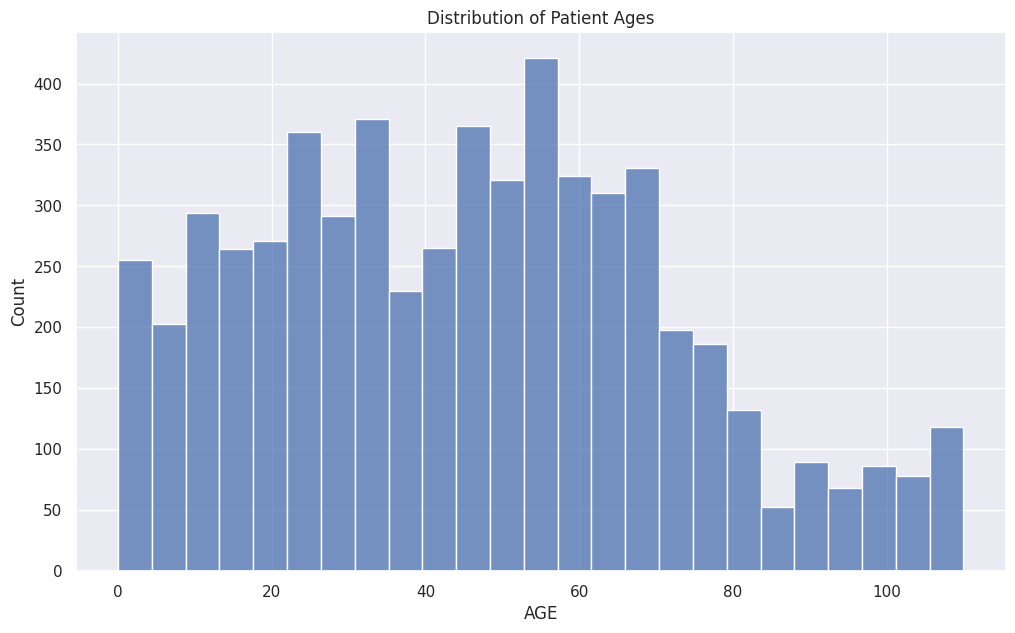

In [10]:
# plot distribution 
sns.histplot(data=patient_df, x='AGE')
plt.title('Distribution of Patient Ages')
plt.show()

### Gender

In [11]:
patient_df['GENDER'].value_counts()

M    2958
F    2927
Name: GENDER, dtype: int64

### Race

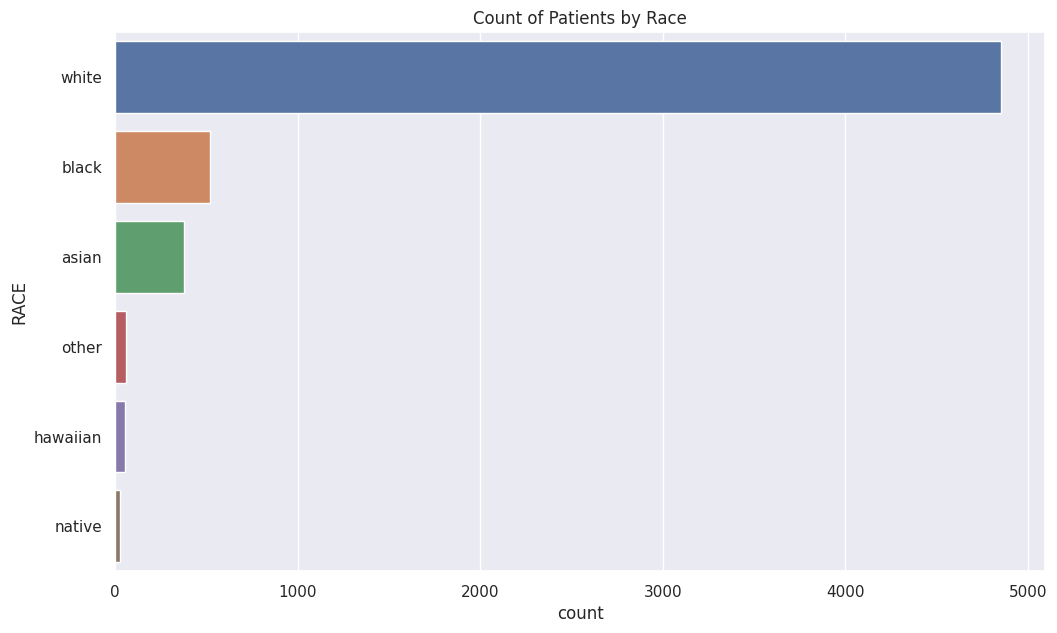

In [12]:
sns.countplot(data=patient_df, 
              y='RACE',
              order=patient_df['RACE'].value_counts().index)
plt.title('Count of Patients by Race')
plt.show()

## Income and Healthcare Expenses 

### Statistical Distributions

In [13]:
patient_df[['HEALTHCARE_EXPENSES', 'INCOME']].describe().round(0)

,HEALTHCARE_EXPENSES,INCOME
count,5885.0,5885.0
mean,136704.0,121165.0
std,326881.0,175711.0
min,100.0,9.0
25%,18520.0,32353.0
50%,44011.0,69718.0
75%,77246.0,128589.0
max,4570388.0,997271.0


### Patient Income

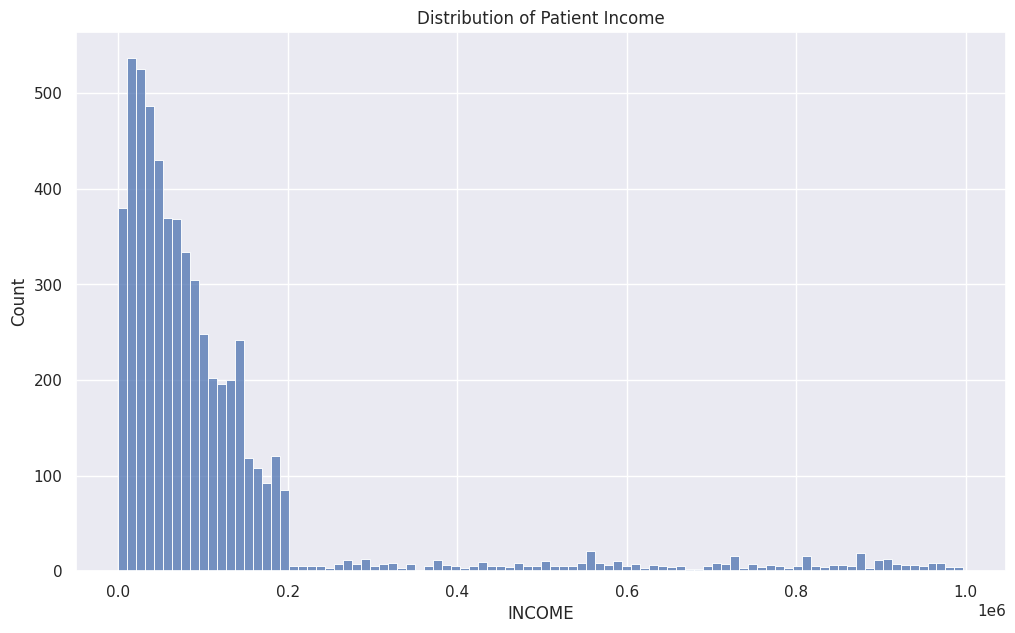

In [14]:
# plot distribution 
sns.histplot(data=patient_df, x='INCOME')
plt.title('Distribution of Patient Income')
plt.show()

### Healthcare Expenses

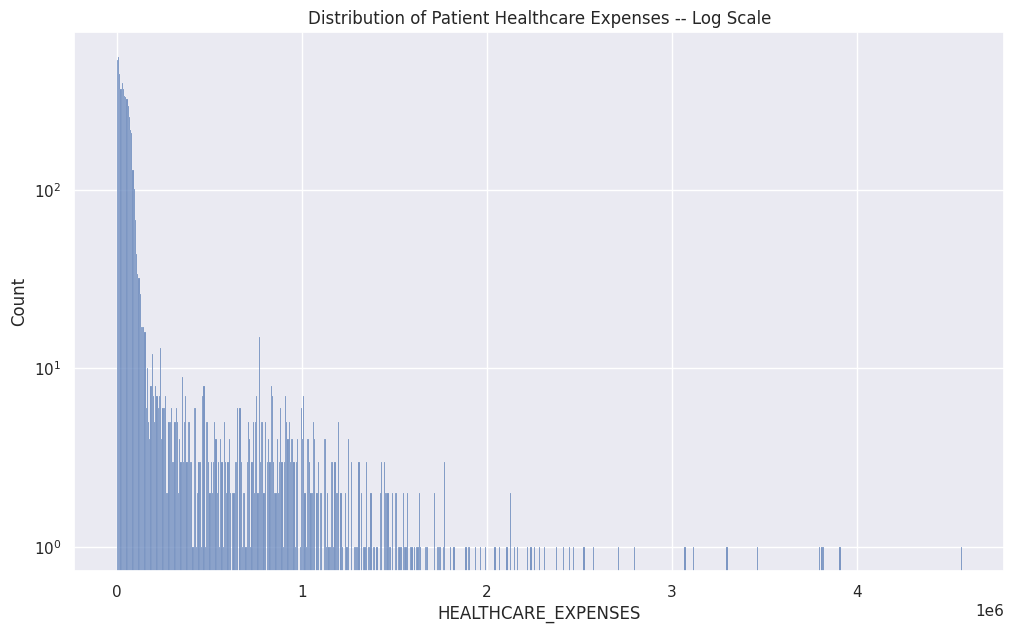

In [15]:
# plot distribution 
sns.histplot(data=patient_df, x='HEALTHCARE_EXPENSES', log=True)
plt.title('Distribution of Patient Healthcare Expenses -- Log Scale')
plt.show()

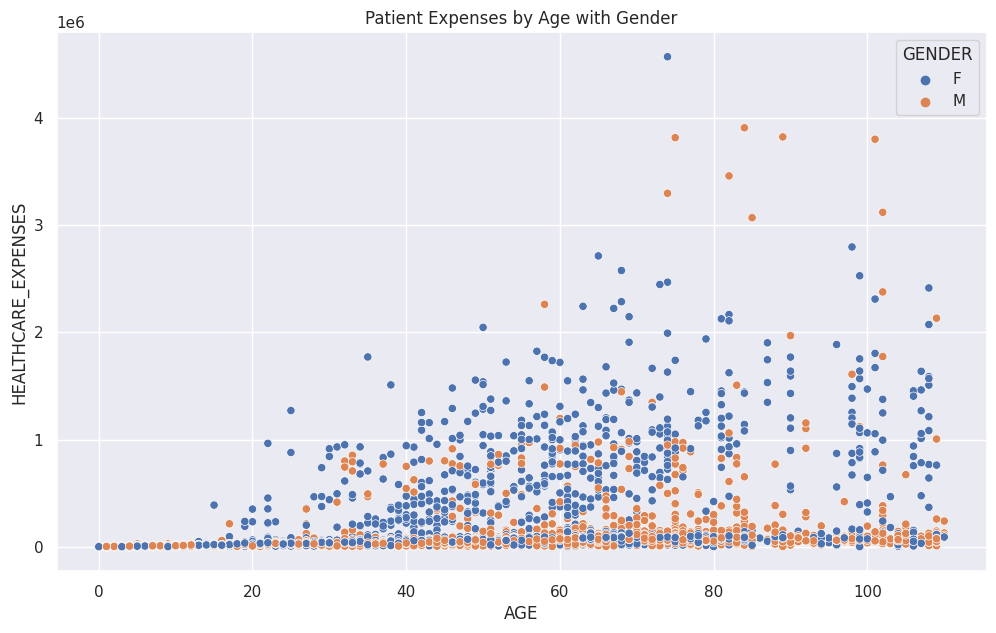

In [16]:
sns.scatterplot(data=patient_df, x='AGE', y='HEALTHCARE_EXPENSES', hue='GENDER')
plt.title('Patient Expenses by Age with Gender')
plt.show()

# Encounters Data

## Overview

In [17]:
encounters_df = pd.read_csv(DATA_DIRECTORY + 'encounters.csv')
encounters_df.shape

(497415, 15)

In [18]:
encounters_df['START'] = pd.to_datetime(encounters_df['START'])
encounters_df['STOP'] = pd.to_datetime(encounters_df['STOP'])

In [19]:
encounters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497415 entries, 0 to 497414
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   Id                   497415 non-null  object             
 1   START                497415 non-null  datetime64[ns, UTC]
 2   STOP                 497415 non-null  datetime64[ns, UTC]
 3   PATIENT              497415 non-null  object             
 4   ORGANIZATION         497415 non-null  object             
 5   PROVIDER             497415 non-null  object             
 6   PAYER                497415 non-null  object             
 7   ENCOUNTERCLASS       497415 non-null  object             
 8   CODE                 497415 non-null  int64              
 9   DESCRIPTION          497415 non-null  object             
 10  BASE_ENCOUNTER_COST  497415 non-null  float64            
 11  TOTAL_CLAIM_COST     497415 non-null  float64            
 12  PA

In [20]:
encounters_df.head(2)

,Id,START,STOP,PATIENT,ORGANIZATION,PROVIDER,PAYER,ENCOUNTERCLASS,CODE,DESCRIPTION,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE,REASONCODE,REASONDESCRIPTION
0,b7d4cb84-84b8-55a6-186c-fc2a9baa9e12,2010-01-15 11:35:37+00:00,2010-01-15 12:28:52+00:00,75bef938-819a-ce94-8dc9-17dc50077a86,fb4a08b8-57ee-382b-b3cb-43d94f1bb4c0,ca383a2c-61e9-319e-8afa-97bc71679361,0133f751-9229-3cfd-815f-b6d4979bdd6a,wellness,162673000,General examination of patient (procedure),136.8,1233.93,1233.93,NaN,NaN
1,896d8330-07e5-9c95-3f71-a9033c13f837,2005-11-21 11:16:28+00:00,2005-11-21 12:03:47+00:00,faf277d8-c5c7-406c-f139-9143c35ff4e8,071a898d-3535-39fd-bf61-d33301aacd04,c7efc940-0b81-3a2b-8d26-c3fcad47abcb,df166300-5a78-3502-a46a-832842197811,wellness,162673000,General examination of patient (procedure),136.8,1302.70,1152.70,NaN,NaN


## Encounter Classes and Descriptions

### Encounter Classes

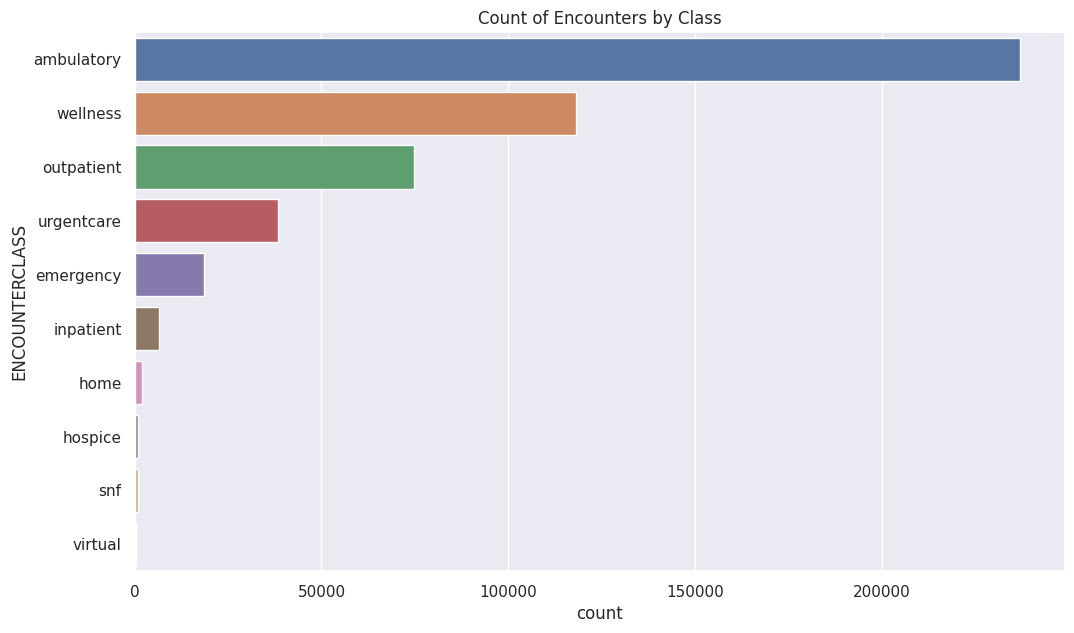

In [21]:
sns.countplot(data=encounters_df, 
              y='ENCOUNTERCLASS',
              order=encounters_df['ENCOUNTERCLASS'].value_counts().index)
plt.title('Count of Encounters by Class')
plt.show()

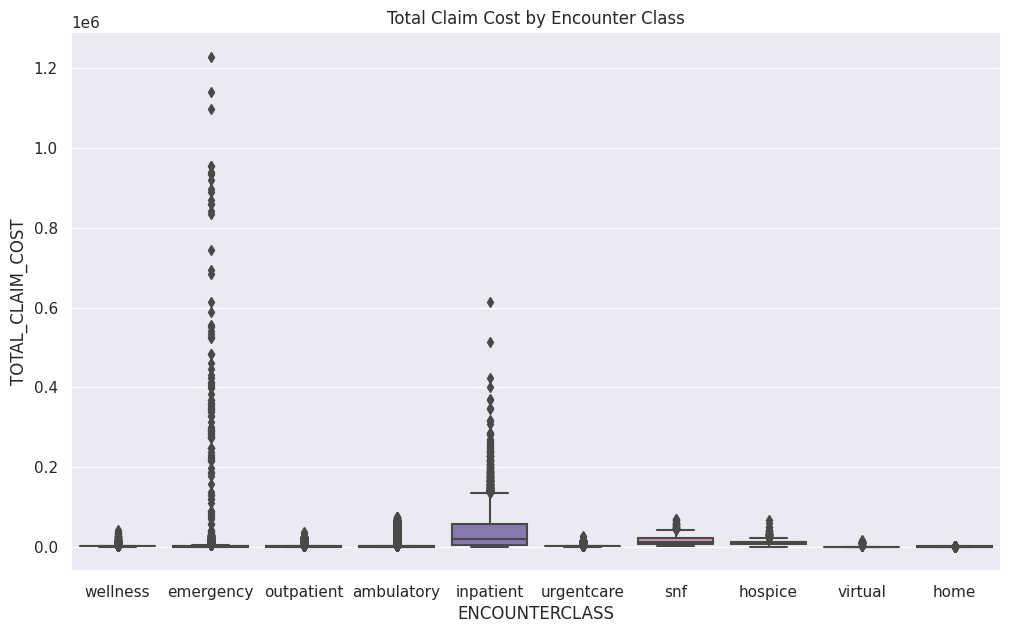

In [22]:
sns.boxplot(data=encounters_df, x='ENCOUNTERCLASS', y='TOTAL_CLAIM_COST')
plt.title('Total Claim Cost by Encounter Class')
plt.show()

In [23]:
encounters_df['DESCRIPTION'].value_counts()

Encounter for problem (procedure)                                         149436
General examination of patient (procedure)                                 96837
Encounter for check up (procedure)                                         49947
Urgent care clinic (procedure)                                             38130
Well child visit (procedure)                                               20354
Encounter for symptom                                                      19211
Prenatal visit                                                             13542
Encounter for problem                                                      11024
Follow-up encounter                                                        10130
Patient encounter procedure                                                 9198
Emergency Encounter                                                         8184
Outpatient procedure                                                        6824
Administration of vaccine to

In [24]:
# view pairings 
(
    encounters_df[['ENCOUNTERCLASS', 'DESCRIPTION']]
    .drop_duplicates()
    .sort_values(by=['ENCOUNTERCLASS', 'DESCRIPTION'], ascending=True)
)

,ENCOUNTERCLASS,DESCRIPTION
5473,ambulatory,Allergic disorder follow-up assessment
349,ambulatory,Allergic disorder initial assessment
3754,ambulatory,Asthma follow-up
522,ambulatory,Discussion about treatment (procedure)
5489,ambulatory,Domiciliary or rest home patient evaluation and management
10,ambulatory,Encounter for 'check-up'
20440,ambulatory,Encounter for Problem
241223,ambulatory,Encounter for check up
60,ambulatory,Encounter for problem
128,ambulatory,Encounter for problem (procedure)


## Encounter Date Ranges

In [25]:
print(encounters_df['START'].dt.date.min())
print(encounters_df['START'].dt.date.max())

1912-09-19
2023-03-11


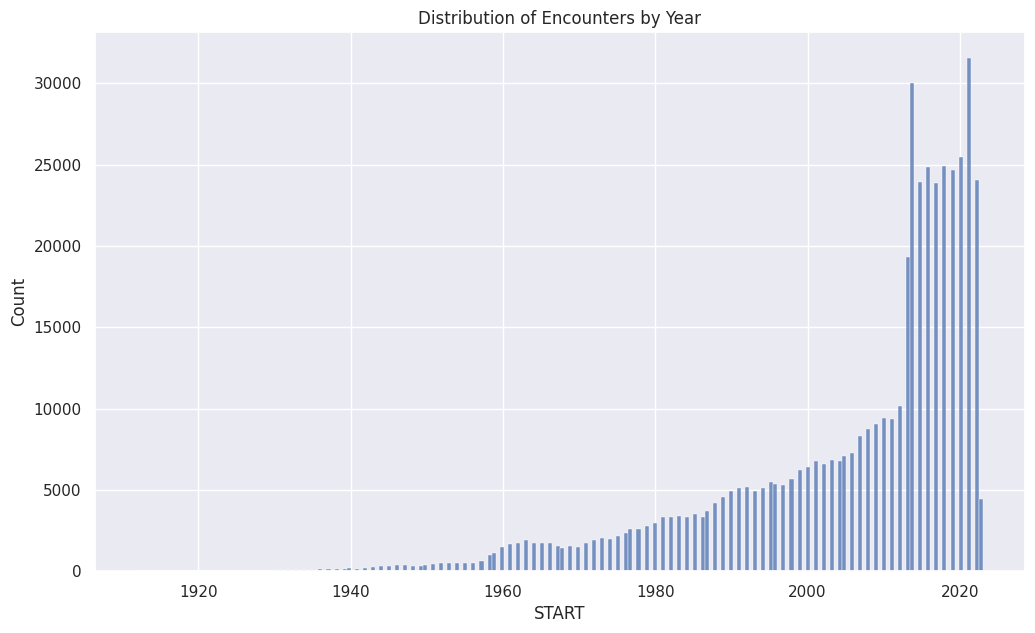

In [26]:
sns.histplot(encounters_df['START'].dt.year)
plt.title('Distribution of Encounters by Year')
plt.show()

### Encounter Costs

In [27]:
encounters_df['TOTAL_CLAIM_COST'].describe().round(0)

count     497415.0
mean        2584.0
std        10610.0
min            0.0
25%          621.0
50%          924.0
75%         1320.0
max      1229194.0
Name: TOTAL_CLAIM_COST, dtype: float64

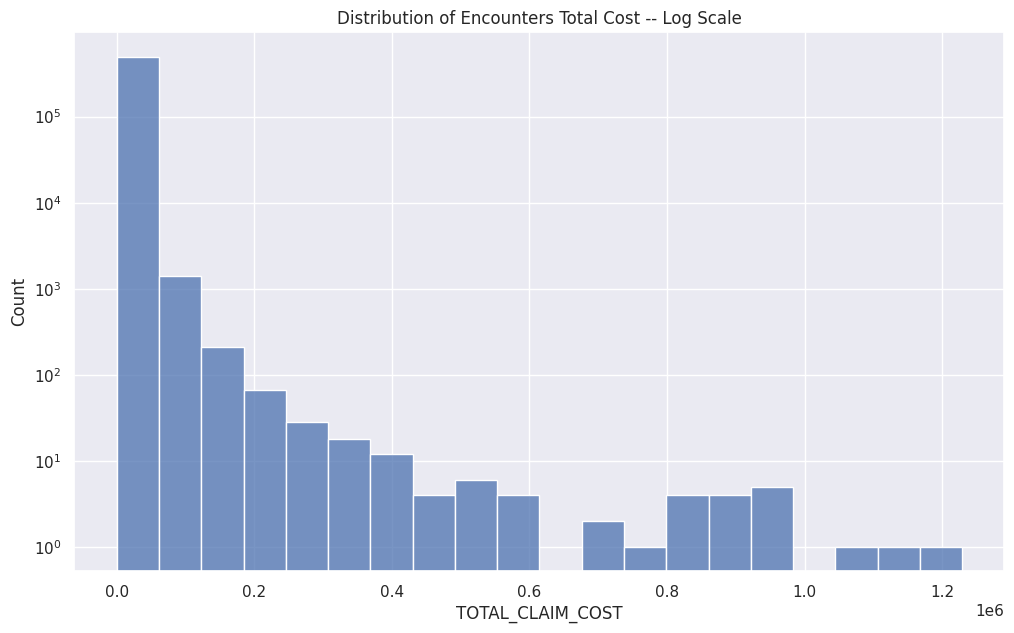

In [59]:
sns.histplot(data=encounters_df['TOTAL_CLAIM_COST'], bins=20, log=True)
plt.title('Distribution of Encounters Total Cost -- Log Scale')
plt.show()

# Procedures Data

In [35]:
procedures_df = pd.read_csv(DATA_DIRECTORY + 'procedures.csv')
procedures_df.shape

(785604, 9)

In [36]:
procedures_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785604 entries, 0 to 785603
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   START              785604 non-null  object 
 1   STOP               785604 non-null  object 
 2   PATIENT            785604 non-null  object 
 3   ENCOUNTER          785604 non-null  object 
 4   CODE               785604 non-null  int64  
 5   DESCRIPTION        785604 non-null  object 
 6   BASE_COST          785604 non-null  float64
 7   REASONCODE         249782 non-null  float64
 8   REASONDESCRIPTION  249782 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 53.9+ MB


In [37]:
procedures_df.head(2)

,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION,BASE_COST,REASONCODE,REASONDESCRIPTION
0,2013-07-24T11:27:37Z,2013-07-24T11:57:37Z,faf277d8-c5c7-406c-f139-9143c35ff4e8,eebc17d4-d133-24f2-3502-a3640d3feaba,268425006,Pelvis X-ray,431.4,NaN,NaN
1,2013-07-24T11:27:37Z,2013-07-24T12:53:37Z,faf277d8-c5c7-406c-f139-9143c35ff4e8,eebc17d4-d133-24f2-3502-a3640d3feaba,305428000,Admission to orthopedic department,431.4,359817006.0,Closed fracture of hip


### Descriptions

In [38]:
# count of unique procedure descriptions
procedures_df['DESCRIPTION'].nunique()

339

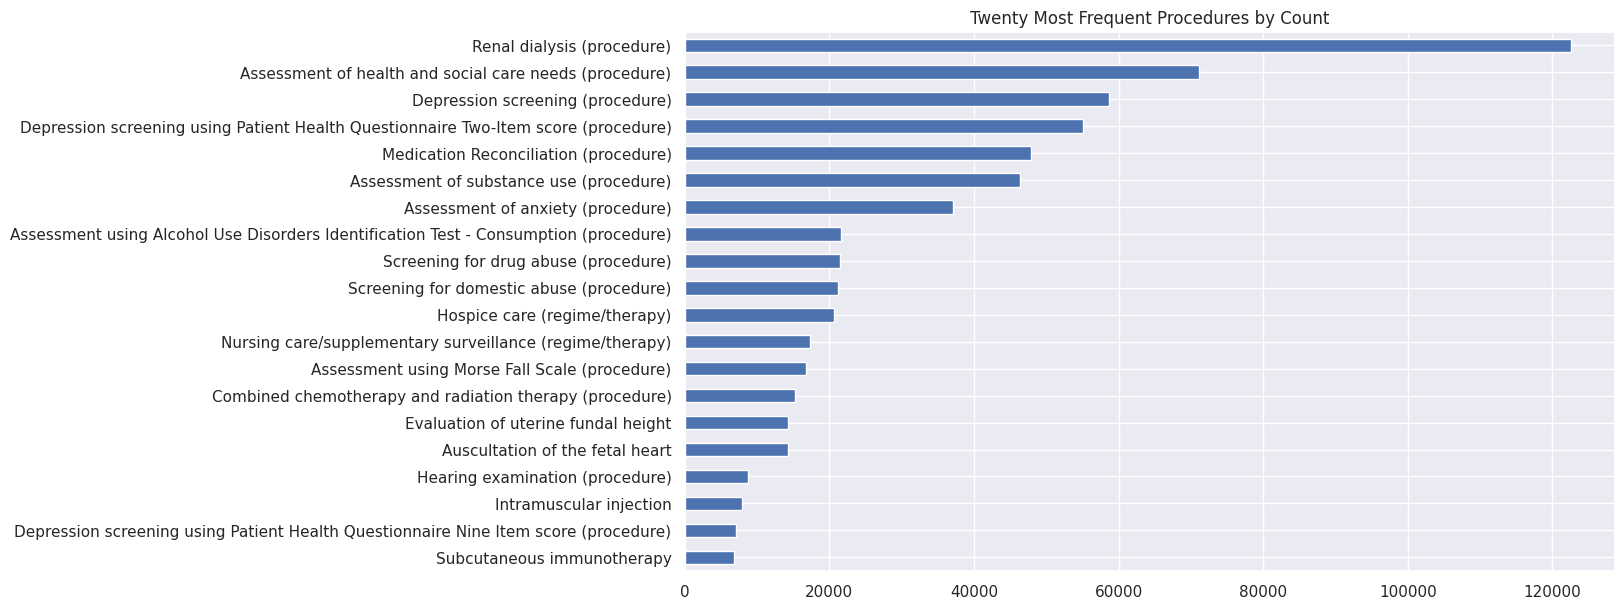

In [45]:
# plot 20 most frequent procedures
procedures_df['DESCRIPTION'].value_counts().head(20).sort_values().plot(kind='barh')
plt.title('Twenty Most Frequent Procedures by Count')
plt.show()

# Medications Data

In [50]:
medications_df = pd.read_csv(DATA_DIRECTORY + 'medications.csv')
medications_df.shape

(604103, 13)

In [51]:
medications_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604103 entries, 0 to 604102
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   START              604103 non-null  object 
 1   STOP               586915 non-null  object 
 2   PATIENT            604103 non-null  object 
 3   PAYER              604103 non-null  object 
 4   ENCOUNTER          604103 non-null  object 
 5   CODE               604103 non-null  int64  
 6   DESCRIPTION        604103 non-null  object 
 7   BASE_COST          604103 non-null  float64
 8   PAYER_COVERAGE     604103 non-null  float64
 9   DISPENSES          604103 non-null  int64  
 10  TOTALCOST          604103 non-null  float64
 11  REASONCODE         550098 non-null  float64
 12  REASONDESCRIPTION  550098 non-null  object 
dtypes: float64(4), int64(2), object(7)
memory usage: 59.9+ MB


In [52]:
medications_df.head(2)

,START,STOP,PATIENT,PAYER,ENCOUNTER,CODE,DESCRIPTION,BASE_COST,PAYER_COVERAGE,DISPENSES,TOTALCOST,REASONCODE,REASONDESCRIPTION
0,2013-07-24T12:53:37Z,2013-08-20T11:16:28Z,faf277d8-c5c7-406c-f139-9143c35ff4e8,df166300-5a78-3502-a46a-832842197811,eebc17d4-d133-24f2-3502-a3640d3feaba,861467,Meperidine Hydrochloride 50 MG Oral Tablet,53.88,0.0,1,53.88,NaN,NaN
1,2013-07-24T12:53:37Z,2013-10-01T12:53:37Z,faf277d8-c5c7-406c-f139-9143c35ff4e8,df166300-5a78-3502-a46a-832842197811,eebc17d4-d133-24f2-3502-a3640d3feaba,313782,Acetaminophen 325 MG Oral Tablet,124.87,0.0,2,249.74,NaN,NaN


### Description

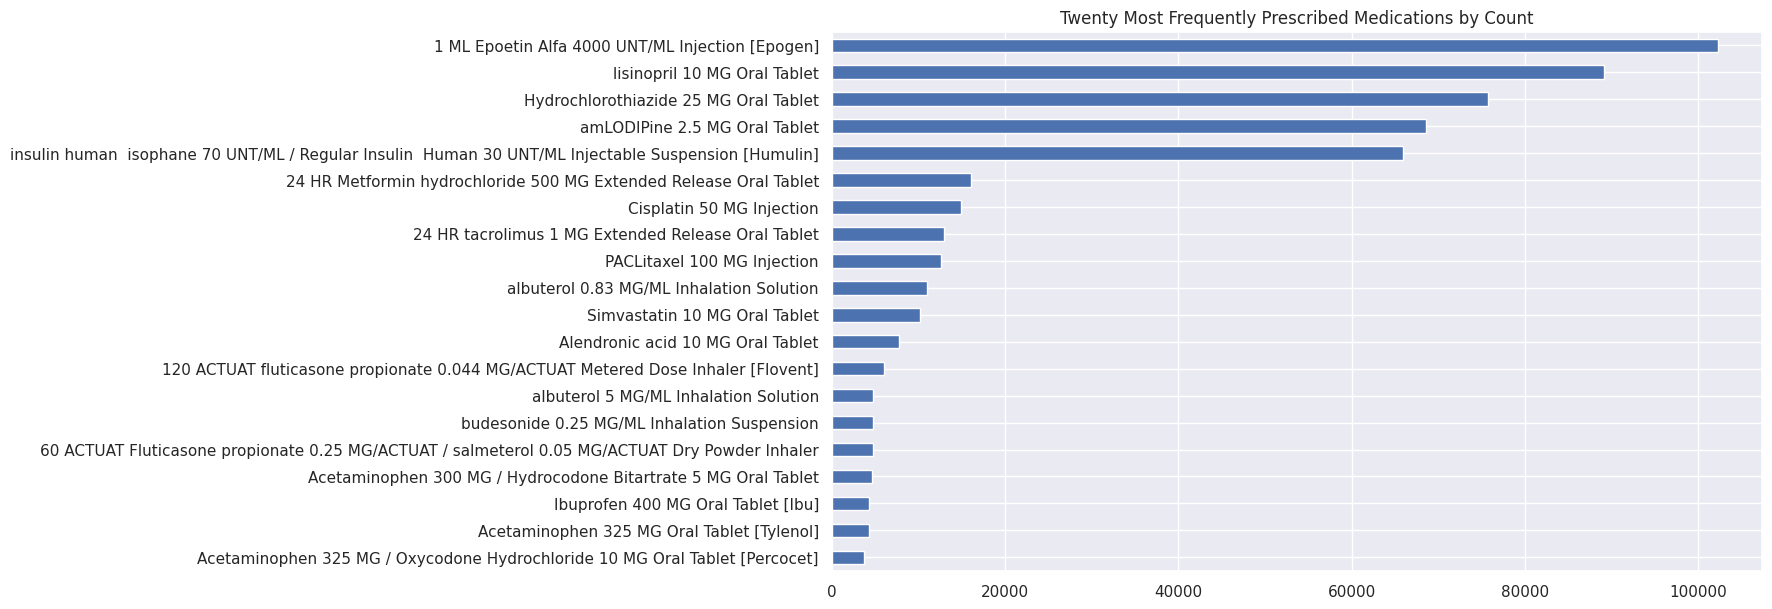

In [55]:
# plot 20 most frequent descriptions
medications_df['DESCRIPTION'].value_counts().head(20).sort_values().plot(kind='barh')
plt.title('Twenty Most Frequently Prescribed Medications by Count')
plt.show()

### Total Cost

In [56]:
medications_df['TOTALCOST'].describe().round(0)

count      604103.0
mean         2002.0
std        171405.0
min             0.0
25%             1.0
50%            30.0
75%           130.0
max      41222678.0
Name: TOTALCOST, dtype: float64

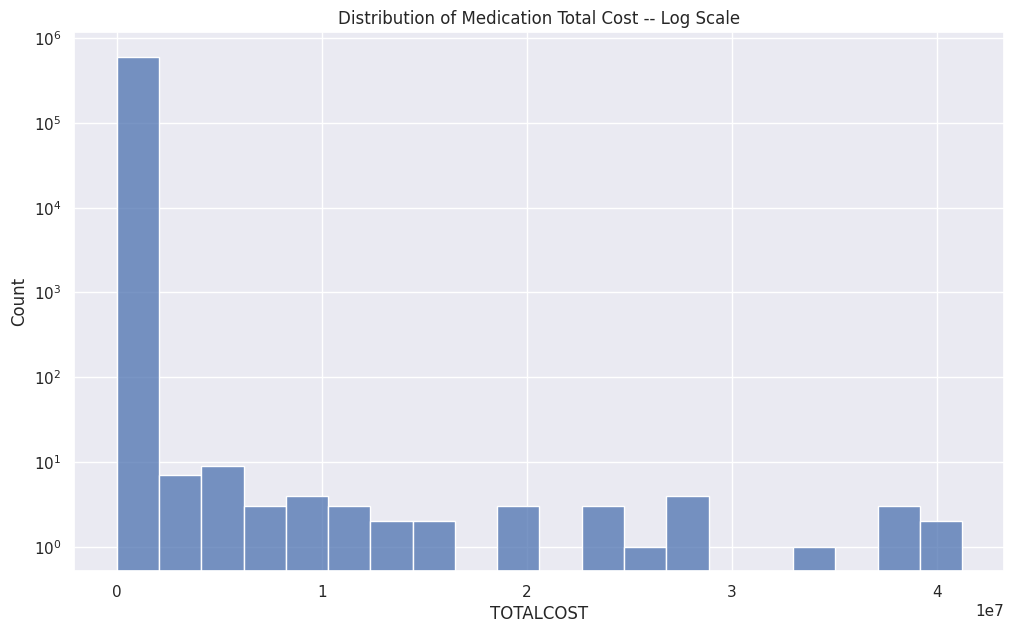

In [58]:
sns.histplot(data=medications_df['TOTALCOST'], bins=20, log=True)
plt.title('Distribution of Medication Total Cost -- Log Scale')
plt.show()

### Reason Description

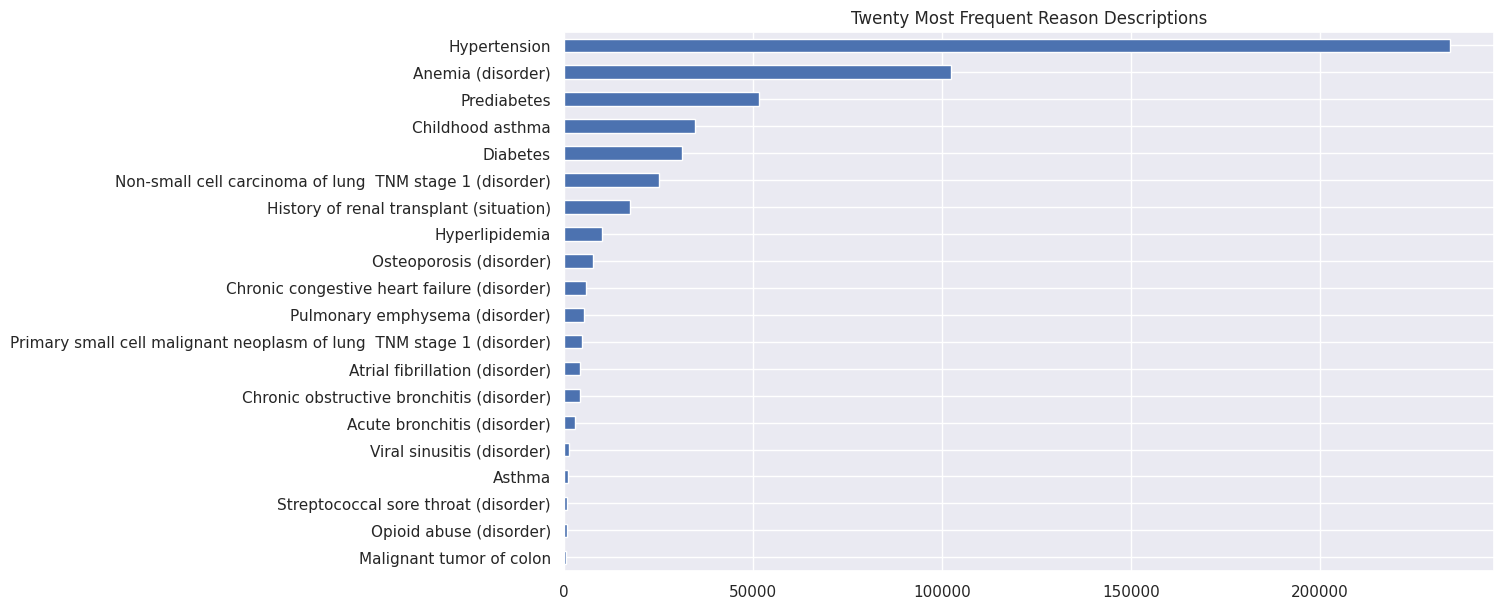

In [62]:
# plot 20 most frequent descriptions
medications_df['REASONDESCRIPTION'].value_counts().head(20).sort_values().plot(kind='barh')
plt.title('Twenty Most Frequent Reason Descriptions')
plt.show()